In [71]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import calendar
from datetime import date
import io
import wordcloud
from shapely import wkt
import folium
from folium.plugins import MarkerCluster

In [112]:
import boto3

# Create an S3 resource object
s3 = boto3.resource('s3')

# Specify the bucket name
bucket_name = 'kansas-city-crime-dataset'

# Get a list of objects in the bucket
bucket = s3.Bucket(bucket_name)
objects = bucket.objects.all()
file_list=[]
# Iterate through the objects and print their keys
for obj in objects:
    file_list.append(obj.key)


In [73]:
col_list= ['Report_No', 'Reported_Date','From_Time', 'Offense','Sex','Race','Description',
       'Address', 'City', 'Zip Code','Involvement','Area','Fire_Arm_Used_Flag','Location']

df_lst=[]

#Reading files from the Folder

for file in file_list:
    if file.startswith("KCPD"):
        df=pd.read_csv('s3://kansas-city-crime-dataset/'+file,usecols=col_list,low_memory=False)
        df_lst.append(df)

df=pd.concat(df_lst,axis=0,ignore_index=True)
df.head(3)
df.columns=['Report_No', 'Reported_Date', 'From_Time', 'Offense', 'Description',
       'Address', 'City', 'Zip_Code', 'Area', 'Involvement', 'Race', 'Sex',
       'Fire_Arm_Used_Flag','Location']
df.columns

Index(['Report_No', 'Reported_Date', 'From_Time', 'Offense', 'Description',
       'Address', 'City', 'Zip_Code', 'Area', 'Involvement', 'Race', 'Sex',
       'Fire_Arm_Used_Flag', 'Location'],
      dtype='object')

In [74]:
df.head(3)


,Report_No,Reported_Date,From_Time,Offense,Description,Address,City,Zip_Code,Area,Involvement,Race,Sex,Fire_Arm_Used_Flag,Location
0,170096892.0,11/14/2017,15:06,630.0,Stealing Shoplifting,200 W 6TH,KANSAS CITY,64105.0,NaN,VIC,NaN,NaN,N,200 W 6TH\nKANSAS CITY 64105
1,170021297.0,03/25/2017,18:26,1850.0,Possession of Drug E,8900 E US 40 HW,KANSAS CITY,64129.0,EPD,VIC,NaN,NaN,N,8900 E US\nHW KANSAS CITY 64129
2,170069219.0,08-07-2017,14:40,2655.0,Trespassing,7100 NW BARRY RD,KANSAS CITY,64151.0,NPD,VIC,NaN,NaN,N,7100 NW BARRY RD\nKANSAS CITY 64151


In [75]:
loc_col = df.loc[:, ['Location','Description']]
df.drop(columns=['Location'], inplace=True)


In [76]:
df.head()

,Report_No,Reported_Date,From_Time,Offense,Description,Address,City,Zip_Code,Area,Involvement,Race,Sex,Fire_Arm_Used_Flag
0,170096892.0,11/14/2017,15:06,630.0,Stealing Shoplifting,200 W 6TH,KANSAS CITY,64105.0,NaN,VIC,NaN,NaN,N
1,170021297.0,03/25/2017,18:26,1850.0,Possession of Drug E,8900 E US 40 HW,KANSAS CITY,64129.0,EPD,VIC,NaN,NaN,N
2,170069219.0,08-07-2017,14:40,2655.0,Trespassing,7100 NW BARRY RD,KANSAS CITY,64151.0,NPD,VIC,NaN,NaN,N
3,170107018.0,12/23/2017,20:10,802.0,Non Aggravated Assault Domestic,7000 E 113 TE,KANSAS CITY,64134.0,SPD,VIC,B,F,N
4,170077301.0,09-04-2017,18:00,302.0,Armed Robbery,E 39 ST and NORTON AV,KANSAS CITY,64130.0,EPD,SUS,B,M,N


In [77]:
# Dropping the Null columns
df=df.dropna()

# Extracting year,hour, month, Day from the Reported_Date
df['year']=df['Reported_Date'].str[6:]
df['year']= df['year'].astype(int)
df['Full_Address']= df['Address'] + ' '+ df['City'] +  ' '+ df['Zip_Code'].astype(str)
df['month']=df['Reported_Date'].str[0:2]
df['month']= df['month'].astype(int)
df['Day_of_Week'] = df['Reported_Date'].apply(lambda x: pd.Timestamp(x).day_name())
df=df[df['year'].isin([2017,2018,2019,2020,2021,2022])]
df['hour']= df['From_Time'].str[0:2]
df.drop(df[df['hour']==':'].index, inplace=True)
df['hour']= df['hour'].astype(int)

# converting Description column to lower case
df['Description']=df['Description'].apply(lambda x: x.lower())

df=df[df['Race'].isin(['B','I','U','W'])]


# Extracting only the columns that has city name with kan to make sure it only has kansas city
df=df[df['City'].str.startswith('KAN')]
df['City']='KANSAS CITY'

In [78]:
#Removing the duplicate values from the dataframe

df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [79]:
# the below function is used to compare the values in the hour column and if it is between [18,6] then its night else its day.

def day_time_cal(x):
    if (x>=18) or (x<=6):
        return 'night'
    else:
        return 'day'
df['Light']= df['hour'].apply(day_time_cal)

In [80]:
# Performing groupby to groups rows that have the same values into summary rows

df.groupby('Fire_Arm_Used_Flag')['Reported_Date'].count()

Fire_Arm_Used_Flag
False    216494
True      20886
N        183726
Y         13245
Name: Reported_Date, dtype: int64

In [81]:
# From the replacing False with N and true with Y

df['Fire_Arm_Used_Flag']= df['Fire_Arm_Used_Flag'].replace({False:'N',True:'Y'})

In [82]:
# Performing groupby to groups Fire_Arm_Used_Flag rows that have the same values into summary rows

df.groupby('Fire_Arm_Used_Flag')['Reported_Date'].count()

Fire_Arm_Used_Flag
N    400220
Y     34131
Name: Reported_Date, dtype: int64

In [83]:
# Performing groupby to group year rows that have the same values into summary rows

grp_year = df.groupby(['year'])['Report_No'].count()
grp_year

year
2017    99374
2018    97656
2019    41115
2020    61588
2021    65606
2022    69012
Name: Report_No, dtype: int64

In [84]:
# Performing groupby to month  rows that have the same values into summary rows

grp_month = df.groupby(['month'])['Report_No'].count()
grp_month

month
1     31146
2     27718
3     32911
4     35231
5     39008
6     39016
7     41354
8     41401
9     40277
10    39748
11    34835
12    31706
Name: Report_No, dtype: int64

In [85]:
# Performing groupby to group Day_of_week rows that have the same values into summary rows

grp_day=df.groupby(['Day_of_Week'])['Report_No'].count()
grp_day = grp_day.reindex(
    index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
grp_day

Day_of_Week
Monday       65756
Tuesday      63732
Wednesday    62621
Thursday     60658
Friday       61898
Saturday     60157
Sunday       59529
Name: Report_No, dtype: int64

In [86]:
# Performing groupby to compare the crime count in day and night

light_count = df.groupby(['Light'])['Report_No'].count()
#print('Most crimes were committed during the', light_count.idxmax())
light_count

Light
day      207041
night    227310
Name: Report_No, dtype: int64

In [87]:
# Performing groupby to group Area rows that have the same values into summary rows
grp_area=df.groupby(['Area'])['Report_No'].count()
grp_area

Area
CPD     107582
EPD     110711
MPD      86591
NPD      34915
OSPD        34
SCP      41567
SPD      52951
Name: Report_No, dtype: int64

In [88]:
#  Performing groupby to  know the area with most shooting happened

shootings_area_grp = df.loc[df['Fire_Arm_Used_Flag'] == 'Y'].groupby(
    ['Area'])['Report_No'].count()
#print('District with most shootings is', shootings_area_grp.idxmax())
shootings_area_grp

Area
CPD      6373
EPD     12541
MPD      8369
NPD       968
OSPD       16
SCP      1451
SPD      4413
Name: Report_No, dtype: int64

In [89]:
#  Performing groupby to find the count of male and female involved in crime

df.groupby(['Sex'])['Report_No'].count()

df=df[df['Sex'].isin(['F','M','U'])]
df_sex_year=df.groupby(['Sex','year'])['Report_No'].count()

In [90]:
def make_plot(series, xlabel, ylabel, title, s3_bucket, image_name, legend):
    """ Make a bar plot on the given series and save it to S3."""
    sns.set(style="darkgrid")

    norm = plt.Normalize(0, series.values.max())
    colors = plt.cm.Blues(norm(series.values))
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=series.index, y=series.values, palette=colors)
    ax.set(ylabel=ylabel, xlabel=xlabel)
    plt.title(title)
    plt.legend(legend)

    # save plot to an in-memory buffer
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)

    # upload image to S3
    s3 = boto3.resource('s3')
    s3.Object(s3_bucket, 'output/' + image_name).put(Body=buffer)

    plt.show()
    plt.close()

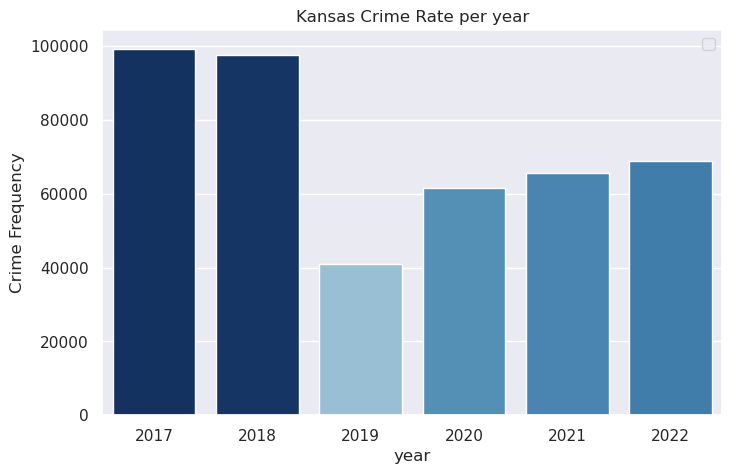

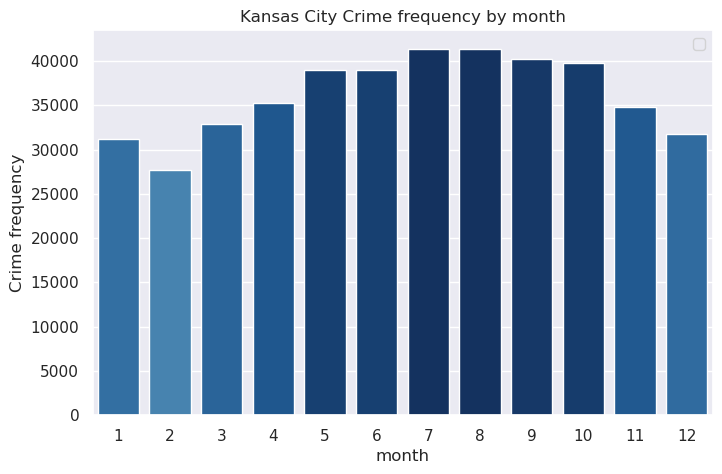

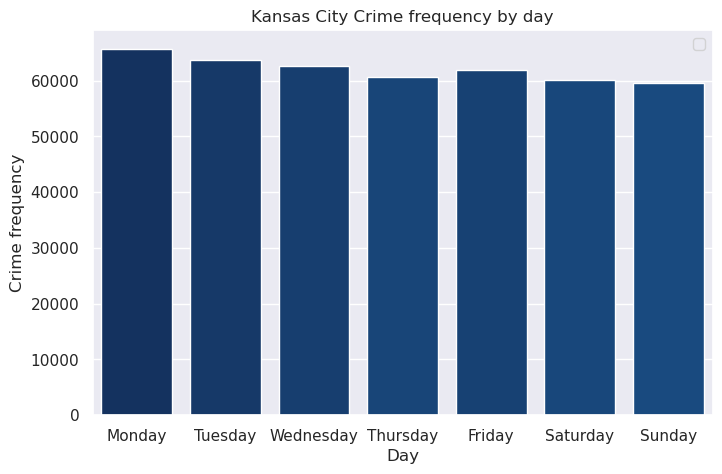

In [91]:
# assigning the path to store the output images of the barplots

s3_bucket = "kansas-city-crime-dataset"

# calling the make_plot function with different groupby variables for plotting
make_plot(grp_year, 'year', 'Crime Frequency',
          'Kansas Crime Rate per year', s3_bucket, 'year.png','')
make_plot(grp_month, 'month', 'Crime frequency',
          'Kansas City Crime frequency by month', s3_bucket, 'month.png','')
make_plot(grp_day, 'Day', 'Crime frequency',
          'Kansas City Crime frequency by day', s3_bucket, 'day.png','')

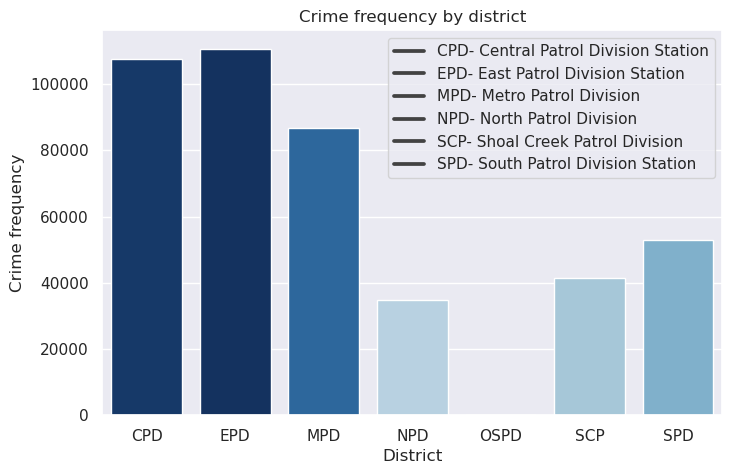

In [92]:
# calling the make_plot function to analyse area wise crime.
make_plot(grp_area, 'District', 'Crime frequency',
          'Crime frequency by district', s3_bucket, 'district.png',['CPD- Central Patrol Division Station','EPD- East Patrol Division Station','MPD- Metro Patrol Division','NPD- North Patrol Division','SCP- Shoal Creek Patrol Division','SPD- South Patrol Division Station'])

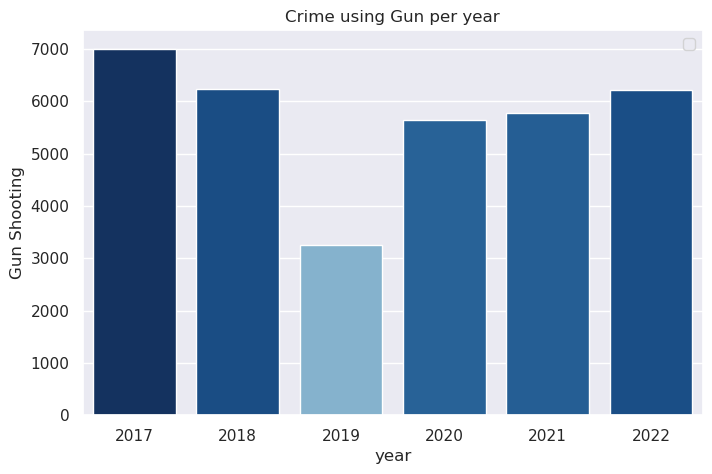

In [93]:
shootings_year_group = df.loc[df['Fire_Arm_Used_Flag'] == 'Y'].groupby(
    ['year'])['Report_No'].count()
#print('Year with most shootings is', shootings_year_group.idxmax())
# make_plot function to create barplot for the differnet variables for the above groupby variables
make_plot(shootings_year_group, 'year', 'Gun Shooting',
          'Crime using Gun per year',s3_bucket, 'shooting_year.png','')

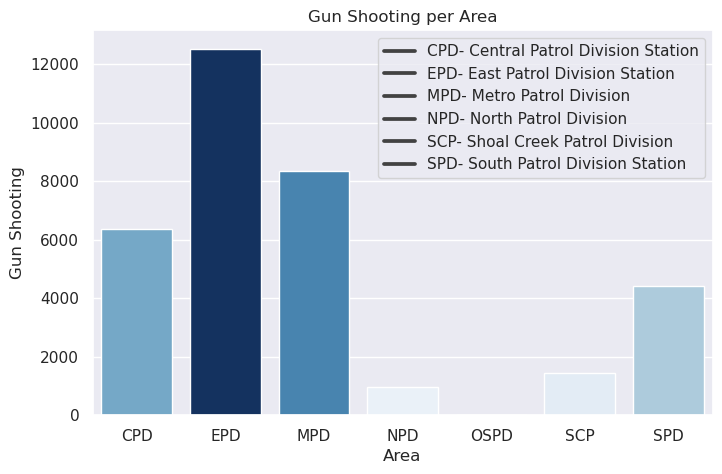

In [94]:
# make_plot function to create barplot for the differnet variables for the above groupby variables.
make_plot(shootings_area_grp, 'Area', 'Gun Shooting',
          'Gun Shooting per Area',s3_bucket, 'shooting_area.png',['CPD- Central Patrol Division Station','EPD- East Patrol Division Station','MPD- Metro Patrol Division','NPD- North Patrol Division','SCP- Shoal Creek Patrol Division','SPD- South Patrol Division Station'])

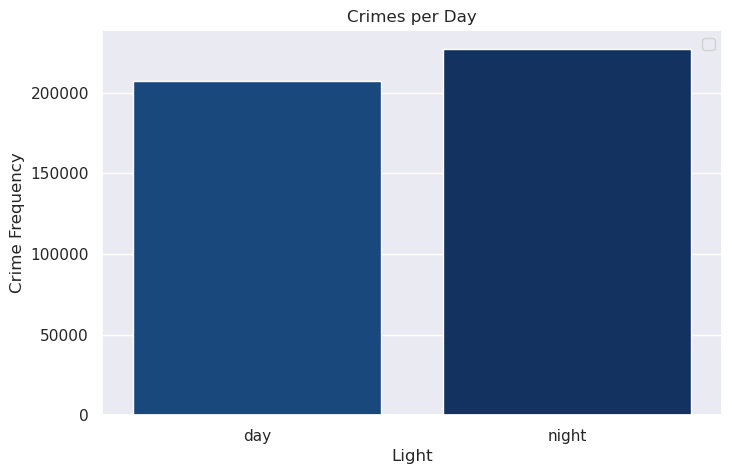

In [95]:
make_plot(light_count, 'Light', 'Crime Frequency',
          'Crimes per Day',s3_bucket, 'light.png','')

In [96]:
# Finding the most frequent type of crime in night time

light_group = df.loc[df['Light'] == 'night'].groupby(
    ['Description'])['Report_No'].count()
print('Most frequent type of crime during the Night is', light_group.idxmax())

Most frequent type of crime during the Night is motor vehicle theft


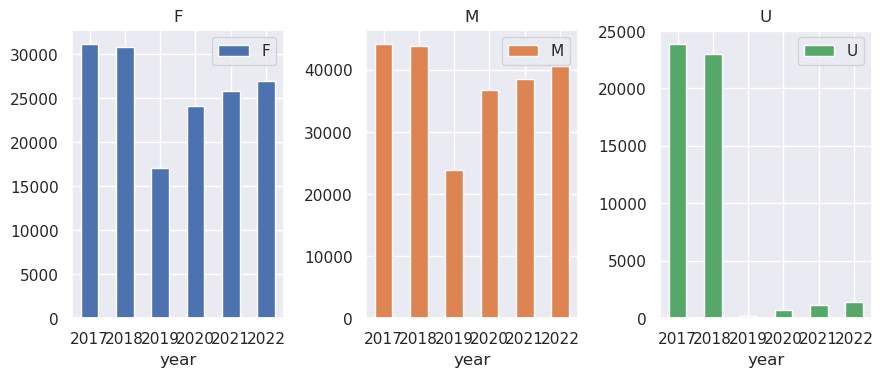

In [97]:
# Displaying the number count of male and female involved in the crime
ax = df_sex_year.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(2, 3))
plt.tight_layout()

In [98]:
grp_race=df.groupby(['Race'])['Report_No'].count()
grp_race

Race
B    186192
I       986
U     63123
W    184050
Name: Report_No, dtype: int64

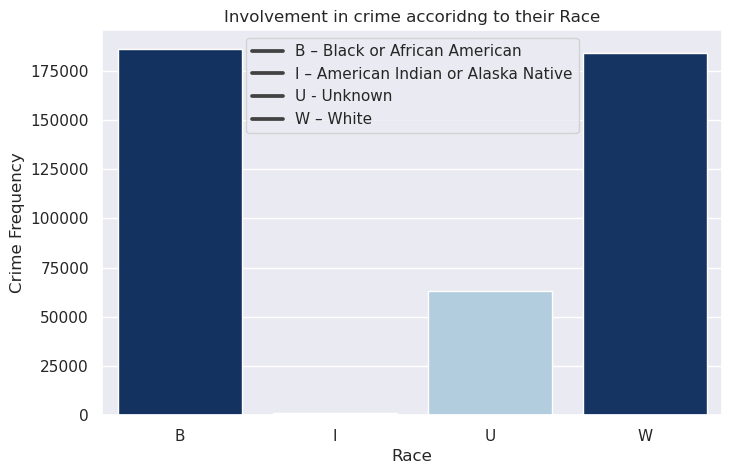

In [99]:
make_plot(grp_race, 'Race', 'Crime Frequency',
          'Involvement in crime accoridng to their Race',s3_bucket, 'Race_grp.png',['B – Black or African American', 'I – American Indian or Alaska Native', 'U - Unknown', 'W – White'])

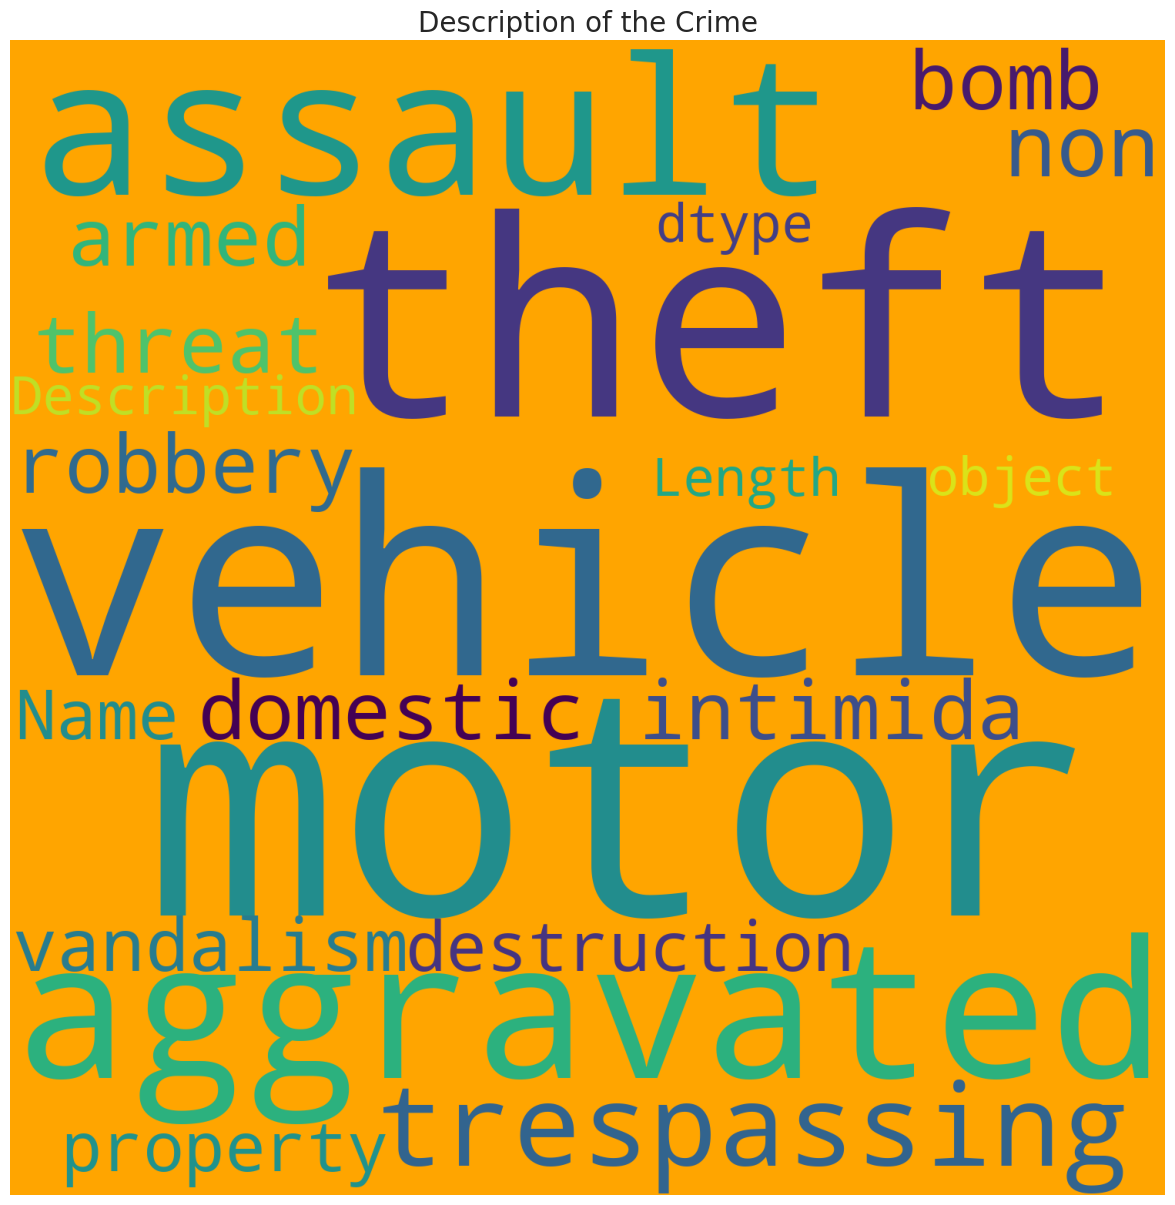

{'ResponseMetadata': {'RequestId': 'EPJS2BVVRV94679J',
  'HostId': 'O8orai0SiYzyJQZox7qf47+AdiblObpbedwx9pM3wxv9Rf0qj9qnZPp/rmgSYRogX4vbXybC3Go=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'O8orai0SiYzyJQZox7qf47+AdiblObpbedwx9pM3wxv9Rf0qj9qnZPp/rmgSYRogX4vbXybC3Go=',
   'x-amz-request-id': 'EPJS2BVVRV94679J',
   'date': 'Tue, 09 May 2023 17:34:53 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"b29ea6fbb96a7434c2d98394b1bb3317"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"b29ea6fbb96a7434c2d98394b1bb3317"',
 'ServerSideEncryption': 'AES256'}

<Figure size 1500x1500 with 0 Axes>

In [111]:
# description of the crime

from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (15, 15)
plt.style.use('fast')
wc = WordCloud(background_color = 'orange', width = 1500, height = 1500).generate(str(df['Description']))

plt.title('Description of the Crime', fontsize = 20)
plt.imshow(wc)
plt.axis('off')
plt.show()
# save the plot to a buffer
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)

# upload the plot to S3
s3 = boto3.resource('s3')
bucket_name = s3_bucket
s3_key = 'output/top_crime_description.png'  # set the desired prefix for the S3 key
s3.Object(bucket_name, s3_key).put(Body=buf)

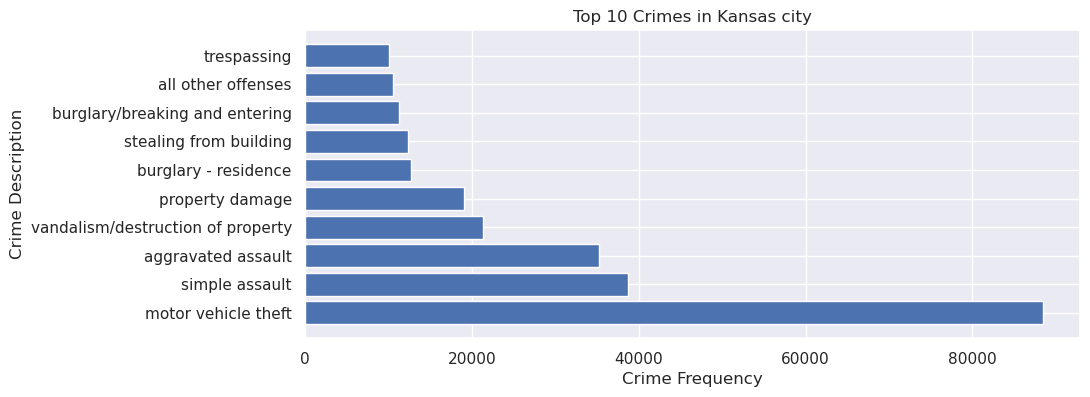

{'ResponseMetadata': {'RequestId': 'MKA8NHXQZ4XPNSR7',
  'HostId': 'M+neuQIjLWP9LdmRfLoLqJfH/7Bngp3l7vM4YWV13+TMx/F5ObCDAwbTsgFciiRjohVoxEzLeQY=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'M+neuQIjLWP9LdmRfLoLqJfH/7Bngp3l7vM4YWV13+TMx/F5ObCDAwbTsgFciiRjohVoxEzLeQY=',
   'x-amz-request-id': 'MKA8NHXQZ4XPNSR7',
   'date': 'Tue, 09 May 2023 17:33:39 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"b29ea6fbb96a7434c2d98394b1bb3317"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"b29ea6fbb96a7434c2d98394b1bb3317"',
 'ServerSideEncryption': 'AES256'}

<Figure size 1500x1500 with 0 Axes>

In [110]:
crime_desc = df['Description'].value_counts(ascending=False)
top_crimes=crime_desc.head(10)
plt.figure(figsize=(10,4))
plt.barh(top_crimes.index, top_crimes.values)
plt.ylabel("Crime Description") 
 
# setting label of x-axis
plt.xlabel("Crime Frequency")
plt.title("Top 10 Crimes in Kansas city")
plt.show()
# save the plot to a buffer
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)

# upload the plot to S3
s3 = boto3.resource('s3')
bucket_name = s3_bucket
s3_key = 'output/top_crimes.png'  # set the desired prefix for the S3 key
s3.Object(bucket_name, s3_key).put(Body=buf)

In [102]:
loc_col = loc_col.dropna()
loc_col = loc_col[loc_col['Location'].str.startswith('POINT')]
loc_col.loc[:, 'Location'] = loc_col['Location'].apply(wkt.loads)
loc_col.loc[:, 'Longitude'] = loc_col['Location'].apply(lambda x: x.x)
loc_col.loc[:, 'Latitude'] = loc_col['Location'].apply(lambda x: x.y)



In [ ]:
# Displaying the crime hotspot locations of last 2 years in the map and the output is saved into S3 bucket in map.html
crime_counts = {}
for desc in loc_col['Description']:
    if desc in crime_counts:
        crime_counts[desc] += 1
    else:
        crime_counts[desc] = 1

# create the map and add markers for each crime location
map = folium.Map(location=[loc_col['Latitude'].mean(), loc_col['Longitude'].mean()], zoom_start=11)
marker_cluster = MarkerCluster().add_to(map)

for index, row in loc_col.iterrows():
    # create the popup text with the crime type and count
    popup_text = f"Crime Type: {row['Description']}<br>Count: {crime_counts[row['Description']]}"
    folium.Marker(location=[row['Latitude'], row['Longitude']], popup=popup_text).add_to(marker_cluster)
    
# save the map as an HTML file
map_html = map._repr_html_()
s3 = boto3.resource('s3')
bucket = s3.Bucket('kansas-city-crime-dataset')
bucket_object = bucket.Object('/output/map.html')
bucket_object.put(Body=BytesIO(map_html.encode()), ContentType='text/html')
